In [1]:
import pandas as pd
import numpy as np
import torch
import os

dataset_path = './dataset/'
dataset_files = ['TcData.csv' ,'BsData.csv']

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

dfs = dict([])
for file in dataset_files:
    df = pd.read_csv(os.path.join(dataset_path,file), na_values=0)
    df = df.rename(columns={'Composition': 'formula'})
    df.name = file[:2]
    dfs[df.name] = df

In [2]:
from utils import add_feature

load_df = True
for df_name, df in dfs.items():
    if load_df:
        dfs[df_name] = pd.read_pickle(os.path.join(dataset_path, f"./df_data_{df.name}.pkl"))
    else:    
        name = df.name
        df = add_feature.add_composition(df)
        df = add_feature.add_element_fraction(df)
        df.name = name
        dfs[df_name] = df 
        df.to_pickle(os.path.join(dataset_path, f"./df_data_{df.name}.pkl"))

In [4]:
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel, ScaleKernel
#from botorch.fit import fit_gpytorch_mll
from torch.optim import SGD, Adam
from botorch.models.transforms.input import ChainedInputTransform
from utils.model import trainGP, NormalizeElementFractions, NormalizeFeatures
from utils.model import test_features_normalized

models = []

outcome_transform1 = Standardize(m=1)
outcome_transform2 = Standardize(m=1)

model_Bs = SingleTaskGP(
    torch.tensor(dfs['Bs']['Fe'].values).unsqueeze(dim=1), 
    torch.tensor(dfs['Bs']['Bs (T)'].values).unsqueeze(dim=1),
    outcome_transform=outcome_transform1,
    covar_module=ScaleKernel(RBFKernel()),
    )

model_Tc = SingleTaskGP(
    torch.tensor(dfs['Tc']['Fe'].values).unsqueeze(dim=1),
    torch.tensor(dfs['Tc']['Tc (K)'].values).unsqueeze(dim=1),
    outcome_transform=outcome_transform2,
    covar_module=ScaleKernel(RBFKernel()),
    )

models = [model_Bs, model_Tc]


for model in models:

    model.train()
    #optimizer_kwargs = {'lr': 1e-2, 'weight_decay': 1e-3}
    optimizer_kwargs = {'lr': 1e-2, 'weight_decay': 1e-4}
    #print(f"Training {model_name}")
    #surrogate_model.model.train()
    trainGP(model,
            mll = ExactMarginalLogLikelihood(model.likelihood, model), 
            optimizer = Adam([{'params': model.parameters()}], **optimizer_kwargs),
            num_epochs=400,
            print_interval = 50 
           )
    print("-------------------")

Epoch  50/400 - Loss: 1.433 noise: 1.506
Epoch 100/400 - Loss: 1.357 noise: 1.025
Epoch 150/400 - Loss: 1.217 noise: 0.686
Epoch 200/400 - Loss: 1.128 noise: 0.504
Epoch 250/400 - Loss: 1.126 noise: 0.497
Epoch 300/400 - Loss: 1.121 noise: 0.489
Epoch 350/400 - Loss: 1.114 noise: 0.477
Epoch 400/400 - Loss: 1.110 noise: 0.473
-------------------
Epoch  50/400 - Loss: 1.462 noise: 1.509
Epoch 100/400 - Loss: 1.364 noise: 1.013
Epoch 150/400 - Loss: 1.344 noise: 0.772
Epoch 200/400 - Loss: 1.304 noise: 0.717
Epoch 250/400 - Loss: 1.291 noise: 0.665
Epoch 300/400 - Loss: 1.280 noise: 0.632
Epoch 350/400 - Loss: 1.279 noise: 0.632
Epoch 400/400 - Loss: 1.279 noise: 0.632
-------------------


In [5]:
from utils.model import evaluateGP

predicted_Tc = []
predicted_Tc_sigma = []

predicted_Bs = []
predicted_Bs_sigma = []
Fe_grid = np.linspace(0,1,101)

for Fe in Fe_grid:
    X = torch.tensor([Fe], **tkwargs).unsqueeze(0)
    mean, sem = evaluateGP(model_Bs,X)
    predicted_Bs.append(mean)
    predicted_Bs_sigma.append(sem)
for Fe in Fe_grid:
    X = torch.tensor([Fe], **tkwargs).unsqueeze(0)
    mean, sem = evaluateGP(model_Tc,X)
    predicted_Tc.append(mean)
    predicted_Tc_sigma.append(sem)

predicted_Tc = np.array(predicted_Tc)
predicted_Tc_sigma = np.array(predicted_Tc_sigma)

predicted_Bs = np.array(predicted_Bs)
predicted_Bs_sigma = np.array(predicted_Bs_sigma)

/Users/ktrerayapiwat/Software/Fe_alloy_phaseshift/utils/model.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  posterior = model.posterior(torch.tensor(X, **tkwargs))


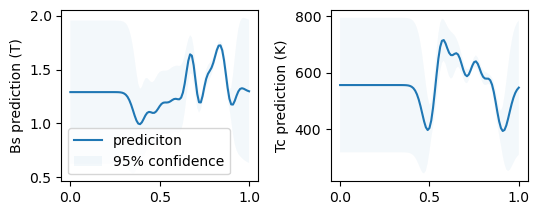

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2, figsize=[5.5,2.25])

axes[0].plot(Fe_grid,predicted_Bs, label = 'prediciton')
axes[0].fill_between(Fe_grid, 
                 predicted_Bs-2*predicted_Bs_sigma, 
                 predicted_Bs+2*predicted_Bs_sigma,
                 alpha = 0.05, label = '95% confidence')
axes[0].set_ylabel('Bs prediction (T)')
#axes[1].legend(loc='upper left')

axes[1].plot(Fe_grid,predicted_Tc, label = 'prediciton')
axes[1].fill_between(Fe_grid, 
                 predicted_Tc-2*predicted_Tc_sigma, 
                 predicted_Tc+2*predicted_Tc_sigma,
                 alpha = 0.05, label = '95% confidence')
axes[1].set_ylabel('Tc prediction (K)')
axes[0].legend(loc='lower left')
fig.tight_layout()
fig.savefig('elemental_Fe_inference.png', dpi=300)

In [17]:
print(f"Tc prediction at elemental Fe = {predicted_Tc[-1]:.02f}",
      "±", f"{2*predicted_Tc_sigma[-1]:.02f} K")

print(f"Bs prediction at elemental Fe = {predicted_Bs[-1]:.02f}",
      "±", f"{2*predicted_Bs_sigma[-1]:.02f} T")

Tc prediction at elemental Fe = 547.20 ± 237.84 K
Bs prediction at elemental Fe = 1.30 ± 0.67 T


Bs prediction at elemental Fe = 1.30 ± 0.67 K
